#### 1. load the dataset



In [1]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import zipfile
import pandas as pd

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1RayMjAmn0PhXM0I-bypjFBwU2RtgDwSw'
downloaded = drive.CreateFile({'id': file_id})

downloaded.GetContentFile('data.zip') 


path = os.listdir('.')
print (path)


with zipfile.ZipFile("data.zip","r") as datazip:
  datazip.extractall("")


data = pd.read_csv("data.csv") 

     |████████████████████████████████| 993kB 9.0MB/s 
['.config', 'data.zip', 'adc.json', 'sample_data']


In [5]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### 2. Normalization
是否要加上时间戳？

In [0]:
data=data.iloc[:100000]

In [0]:
data=data.drop(['UpdateTime', 'UpdateMillisec'],axis=1)
data_norm=(data - data.mean()) / (data.max() - data.min())

#### 3. Build training data

In [0]:
# some parameters
n_samples=len(data)
ratio=0.3
past_n=50
future_n=10
# droplist=['midPrice', 'AskPrice1','BidPrice1','AskVolume1','BidVolume1']


def buildTrain(data,past_n,future_n):
  X_set=[]
  Y_set=[]
  n_samples=len(data)
  for i in range(0,n_samples-past_n-future_n,1): #step=1
    X_set.append(np.array(data.iloc[i:i+past_n]))
    Y_set.append(np.array(data.iloc[i+past_n+future_n-1]["midPrice"]-data.iloc[i+past_n-1]["midPrice"]))
  return np.array(X_set), np.array(Y_set)


def shuffle(X,Y):
  np.random.seed(6)
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]

def tt_split(X,Y,ratio):
  X_train = X[int(X.shape[0]*ratio):]
  Y_train = Y[int(Y.shape[0]*ratio):]
  X_test = X[:int(X.shape[0]*ratio)]
  Y_test = Y[:int(Y.shape[0]*ratio)]
  return X_train, Y_train, X_test, Y_test

X_set, Y_set=buildTrain(data_norm, past_n, future_n)

X_set, Y_set=shuffle(X_set, Y_set)

X_train, Y_train, X_test, Y_test = tt_split(X_set, Y_set, ratio)


In [9]:
print(X_train.shape[1])

50


#### 4. build the model

In [10]:
model = Sequential()
model.add(LSTM(100, input_length=X_train.shape[1], input_dim=X_train.shape[2]))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, input_shape=(50, 137))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               95200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 95,301
Trainable params: 95,301
Non-trainable params: 0
_________________________________________________________________


#### 5. train the model

In [11]:
callback = EarlyStopping(monitor="loss", patience=20, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=100, batch_size=128, validation_data=(X_test, Y_test), callbacks=[callback])

Instructions for updating:
Use tf.cast instead.
Train on 69958 samples, validate on 29982 samples
Epoch 1/100
69958/69958 [==============================] - 53s 755us/step - loss: 1.3135e-04 - val_loss: 2.9551e-05
Epoch 2/100
69958/69958 [==============================] - 49s 695us/step - loss: 2.5905e-05 - val_loss: 1.7643e-05
Epoch 3/100
69958/69958 [==============================] - 48s 693us/step - loss: 2.1476e-05 - val_loss: 2.0123e-05
Epoch 4/100
69958/69958 [==============================] - 47s 670us/step - loss: 1.9652e-05 - val_loss: 1.5038e-05
Epoch 5/100
69958/69958 [==============================] - 48s 690us/step - loss: 2.2024e-05 - val_loss: 1.9749e-05
Epoch 6/100
69958/69958 [==============================] - 47s 670us/step - loss: 1.9017e-05 - val_loss: 2.2234e-05
Epoch 7/100
69958/69958 [==============================] - 50s 710us/step - loss: 1.7443e-05 - val_loss: 1.4469e-05
Epoch 8/100
69958/69958 [==============================] - 49s 700us/step - loss: 1.6982e-

#### 6. evaluation

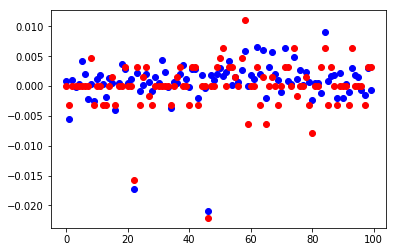

In [16]:
predict_number=100
Y_esitmated=model.predict(X_test[0:predict_number])
fig=plt.figure()
plt.plot(range(predict_number),Y_esitmated,'bo')
plt.plot(range(predict_number),Y_test[0:predict_number],'ro')
plt.show()

In [17]:
model.evaluate(X_test, Y_test, verbose=1)

29982/29982 [==============================] - 28s 933us/step


5.82923933873379e-06

#### 7. conclusion
The loss is small enough ...